In [14]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs # noqa
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
import numpy as np
import pickle


#treescope.basic_interactive_setup()

In [4]:
# Write new configs on wandb.
import wandb

protein_id = "CLN025"
traj_id = 0
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
    updated: bool = False
    if run.state == "finished":
        model_args = asdict(eval(run.config['model_args']))
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

2025-04-29 10:28:57.864 | INFO     | __main__:<module>:20 - Run rozz2o3q was already up to date
2025-04-29 10:28:58.271 | INFO     | __main__:<module>:20 - Run waej21cr was already up to date
2025-04-29 10:28:58.903 | INFO     | __main__:<module>:20 - Run u2s4ft3r was already up to date
2025-04-29 10:28:59.300 | INFO     | __main__:<module>:20 - Run rcucd6gz was already up to date
2025-04-29 10:28:59.675 | INFO     | __main__:<module>:20 - Run nlckxpr3 was already up to date
2025-04-29 10:29:00.087 | INFO     | __main__:<module>:20 - Run ilyqhvx5 was already up to date
2025-04-29 10:29:00.501 | INFO     | __main__:<module>:20 - Run slgxkgi1 was already up to date
2025-04-29 10:29:00.895 | INFO     | __main__:<module>:20 - Run eo8f09k3 was already up to date


In [7]:
run_id = "ilyqhvx5"

In [9]:
def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int = 249, center_covariance: bool = False, progress: bool = True):
    reg=1e-4
    data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run_id}")
    model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()

    dataloader = DataLoader(
        dataset, batch_size=128, shuffle=False
    )

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    cov_X = lol.nn.stats.covariance(phi_t, center=center_covariance)
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = lol.nn.stats.covariance(phi_t, phi_lag, center=center_covariance)
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    r_fun = phi_t.to(Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun
    }
    return model, results

In [10]:
model, results = load_run(run_id, protein_id)

/home/novelli/encoderops/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 168/168 [00:55<00:00,  3.03it/s]


In [ ]:
reg = 1e-4
if Path(f"analysis/results-{protein_id}-{traj_id}.pkl").exists():
    results = pickle.load(open(f"analysis/results-{protein_id}-{traj_id}.pkl", "rb"))
else:
    results = {}
    for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
        if run.state == "finished":
            logger.info(f"Run {run.id}")
            model, run_results = load_run(run.id, protein_id, progress=False)
            results[run.id] = run_results
            pickle.dump(results, open(f"analysis/results-{protein_id}-{traj_id}.pkl", "wb"))

In [11]:
def implied_timescale(ev, lagtime_ns: float = 5.0):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    return np.sort((1/-np.log(np.abs(ev)))*lagtime_ns)[::-1]

In [15]:
print(results['eigenvalues'])

tensor([ 9.9998e-01+0.0000e+00j,  9.8371e-01+0.0000e+00j,
         8.8819e-01+0.0000e+00j,  8.6814e-01+0.0000e+00j,
         7.8346e-01+0.0000e+00j,  6.9498e-01+0.0000e+00j,
         6.1242e-01+0.0000e+00j,  5.7793e-01+0.0000e+00j,
         5.4380e-01+0.0000e+00j,  4.1739e-01+0.0000e+00j,
         2.7680e-01+7.2356e-03j,  2.7680e-01-7.2356e-03j,
         2.5291e-01+0.0000e+00j,  2.1687e-01+0.0000e+00j,
         2.0074e-01+0.0000e+00j,  1.7740e-01+4.5818e-03j,
         1.7740e-01-4.5818e-03j,  1.4944e-01+0.0000e+00j,
         1.2078e-01+5.5363e-03j,  1.2078e-01-5.5363e-03j,
         1.1846e-01+0.0000e+00j,  8.5652e-02+1.0574e-02j,
         8.5652e-02-1.0574e-02j,  7.3193e-02+1.3025e-02j,
         7.3193e-02-1.3025e-02j,  8.0274e-02+0.0000e+00j,
         6.0208e-02+0.0000e+00j,  3.3228e-02+2.0605e-02j,
         3.3228e-02-2.0605e-02j,  4.5208e-02+0.0000e+00j,
         4.0896e-02+0.0000e+00j,  3.3621e-02+1.1914e-02j,
         3.3621e-02-1.1914e-02j,  4.2058e-03+2.2450e-02j,
         4.205

In [16]:
print(implied_timescale(results['eigenvalues']))

[2.1129747e+05 3.0446796e+02 4.2168694e+01 3.5359825e+01 2.0489304e+01
 1.3741227e+01 1.0197109e+01 9.1190567e+00 8.2077312e+00 5.7226095e+00
 3.8937716e+00 3.8937716e+00 3.6370935e+00 3.2712884e+00 3.1137908e+00
 2.8917756e+00 2.8917756e+00 2.6303756e+00 2.3666189e+00 2.3666189e+00
 2.3439000e+00 2.0409019e+00 2.0409019e+00 1.9823058e+00 1.9237654e+00
 1.9237654e+00 1.7793941e+00 1.6147350e+00 1.5640962e+00 1.5424035e+00
 1.5424035e+00 1.4999373e+00 1.4999373e+00 1.3725264e+00 1.3230203e+00
 1.3230203e+00 1.2972258e+00 1.2092208e+00 1.1630704e+00 1.1630704e+00
 1.1411176e+00 1.1411176e+00 1.1179359e+00 1.0327274e+00 9.4203568e-01
 9.4203568e-01 9.0046471e-01 8.9679813e-01 8.9679813e-01 6.1256641e-01
 6.0790604e-01 6.0790604e-01 5.9769326e-01 5.9769326e-01 5.9468323e-01
 5.9468323e-01 5.6333518e-01 5.3905177e-01 5.3657359e-01 5.3657359e-01
 5.1118636e-01 5.1118636e-01 4.9455160e-01 4.9455160e-01]


In [21]:
print(model.get_transfer_operator())

tensor([[ 0.0769, -0.0148, -0.0026,  ...,  0.0457, -0.0249, -0.0477],
        [-0.0116,  0.1406,  0.0559,  ..., -0.0396,  0.0577, -0.0150],
        [ 0.0123, -0.0564,  0.0420,  ..., -0.0301, -0.0029,  0.0367],
        ...,
        [-0.0664,  0.0258, -0.0497,  ...,  0.1320, -0.0981,  0.0149],
        [ 0.0568, -0.0283,  0.0780,  ..., -0.0692,  0.0993, -0.0657],
        [ 0.0262, -0.0148, -0.0967,  ...,  0.0086, -0.0698,  0.0969]],
       device='cuda:0')


In [30]:
print(model.cov.cpu()/cov_X)

tensor([[0.9989, 1.0005, 0.9953,  ..., 0.9761, 1.0186, 1.0514],
        [1.0005, 0.9541, 1.0057,  ..., 0.9477, 1.0081, 0.9990],
        [0.9953, 1.0057, 1.0180,  ..., 0.9837, 1.0222, 1.0539],
        ...,
        [0.9761, 0.9477, 0.9837,  ..., 0.9534, 1.0043, 1.0050],
        [1.0186, 1.0081, 1.0222,  ..., 1.0043, 1.0185, 1.0456],
        [1.0514, 0.9990, 1.0539,  ..., 1.0050, 1.0456, 1.0421]])


In [23]:
from linear_operator_learning.nn.stats import covariance
phi_t = results['embedding_t']
phi_lag = results['embedding_lag']
center_covariance=False
cov_X = covariance(phi_t, center=center_covariance)
cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * 1e-4
cov_XY = covariance(phi_t, phi_lag, center=center_covariance)
G = torch.linalg.solve(cov_X, cov_XY)

In [ ]:
p

fmxldw5g ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=0.2, normalize_lin=True, regularization=0.0001, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)
p52qnu9d ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=None, normalize_lin=True, regularization=0.0001, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)


(0.8, 1.0)

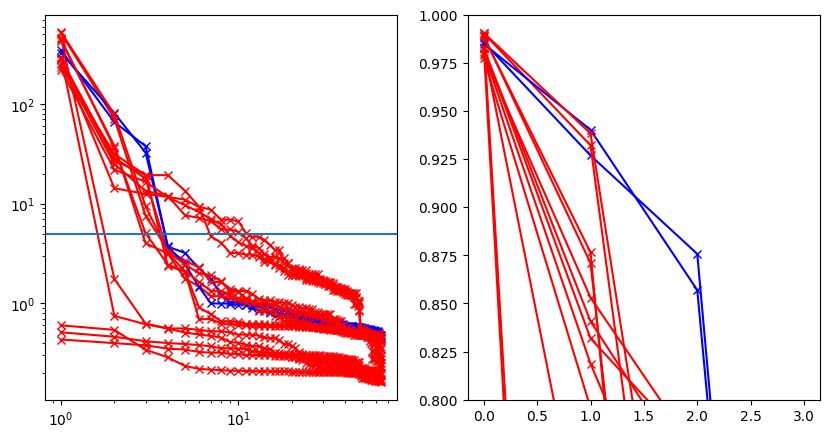

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for run_id, values in results.items():
    data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
    epoch = 249
    model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    color = 'r'
    if model.model_args.regularization == 0.0001:
        if model.model_args.min_encoder_lr is not None:
            if model.model_args.normalize_lin:
            #if model.model_args.max_grad_norm is None:
                color ='b'
                print(run_id, model.model_args)
    
    #color = 'b' if model.model_args.normalize_lin else 'r'
    # color = 'b' if model.model_args.max_grad_norm is None else 'r'
    # color = 'b' if model.model_args.regularization == 0.0001 else 'r'

    ts = implied_timescale(values['eigenvalues'])
    ax[0].plot(range(1, len(ts) + 1), ts, 'x-', label=run_id, color= color)
    ax[1].plot(np.sort(np.abs(values['eigenvalues'][:4]))[::-1], 'x-', color=color)
#plt.yscale('log')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].axhline(5)
#ax[0].set_ylim(2, 100)
ax[1].set_ylim(0.8, 1)

In [26]:
results['p52qnu9d']['eigenvalues']

tensor([ 9.8484e-01+0.0000e+00j,  9.4013e-01+0.0000e+00j,
         8.5693e-01+0.0000e+00j,  2.6214e-01+0.0000e+00j,
         1.2967e-01+0.0000e+00j,  3.2399e-02+0.0000e+00j,
        -6.4544e-03+0.0000e+00j,  3.5873e-03+5.3124e-03j,
         3.5873e-03-5.3124e-03j, -2.2747e-03+5.2251e-03j,
        -2.2747e-03-5.2251e-03j,  3.5793e-03+0.0000e+00j,
         2.5779e-03+8.9778e-04j,  2.5779e-03-8.9778e-04j,
        -3.1976e-04+2.0564e-03j, -3.1976e-04-2.0564e-03j,
        -1.9817e-03+0.0000e+00j, -1.0364e-03+1.1265e-03j,
        -1.0364e-03-1.1265e-03j,  1.3204e-03+4.4131e-04j,
         1.3204e-03-4.4131e-04j, -1.0222e-03+0.0000e+00j,
         1.0048e-03+0.0000e+00j, -2.6973e-04+6.4890e-04j,
        -2.6973e-04-6.4890e-04j,  6.4577e-04+2.6179e-04j,
         6.4577e-04-2.6179e-04j, -5.1204e-04+0.0000e+00j,
         2.2569e-04+4.1714e-04j,  2.2569e-04-4.1714e-04j,
         3.7005e-04+1.1650e-04j,  3.7005e-04-1.1650e-04j,
         2.5493e-04+2.1494e-04j,  2.5493e-04-2.1494e-04j,
         3.2415e-04+0.0000e+00j, -1.8775e-04+2.2895e-04j,
        -1.8775e-04-2.2895e-04j, -4.5248e-05+2.8458e-04j,
        -4.5248e-05-2.8458e-04j,  1.7192e-04+1.0173e-04j,
         1.7192e-04-1.0173e-04j, -2.8459e-05+1.8134e-04j,
        -2.8459e-05-1.8134e-04j, -1.8875e-04+9.7628e-05j,
        -1.8875e-04-9.7628e-05j, -2.1290e-04+0.0000e+00j,
        -1.1740e-04+9.9658e-05j, -1.1740e-04-9.9658e-05j,
        -1.4659e-04+3.2657e-05j, -1.4659e-04-3.2657e-05j,
         1.4170e-04+0.0000e+00j,  8.9544e-05+7.6341e-05j,
         8.9544e-05-7.6341e-05j,  9.3769e-05+1.9199e-05j,
         9.3769e-05-1.9199e-05j, -1.2631e-05+8.1902e-05j,
        -1.2631e-05-8.1902e-05j, -3.9374e-05+6.8125e-05j,
        -3.9374e-05-6.8125e-05j, -8.2747e-05+0.0000e+00j,
        -6.7153e-05+0.0000e+00j,  1.7400e-05+0.0000e+00j,
        -5.9861e-06+1.0662e-05j, -5.9861e-06-1.0662e-05j])

In [25]:
N = phi_t.shape[0]
plt.scatter(results['p52qnu9d']['eigenvalues'].real, results['p52qnu9d']['eigenvalues'].imag, marker='x', label="Ridge Regression new")
#plt.scatter(e1.real, e1.imag, label="end2end")
plt.grid(alpha=0.2)
plt.legend()
# Draw unit circle
t = np.linspace(0, 2 * np.pi, 100)
r = 1
x = r * np.cos(t)
y = r * np.sin(t)
plt.plot(x, y, color='k', lw=0.5)
plt.axis('equal')

NameError: name 'phi_t' is not defined

In [239]:
r_fun = results['p52qnu9d']['r_fun']

In [240]:
from mlcolvar.utils.fes import compute_fes

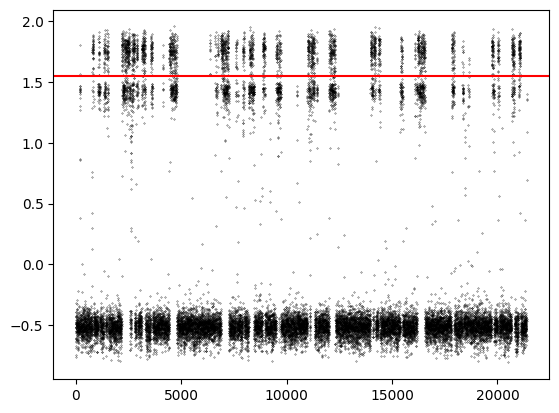

In [252]:
plt.plot(r_fun[:, 0].real, '.', color='k', markersize = 0.5)
plt.axhline(1.55, color='r')

Text(0.5, 1.0, 'They look like they are concentrated on the vertices of a simplex!!!')

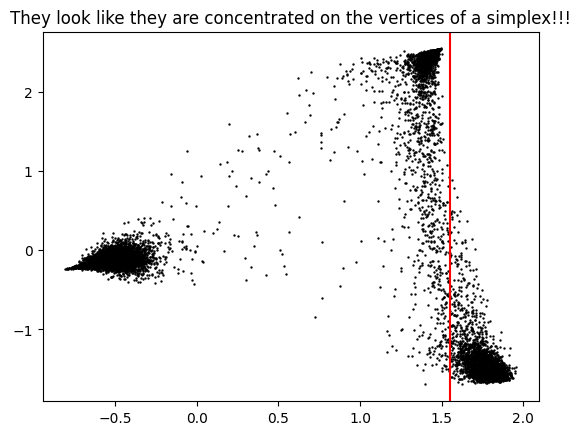

In [255]:
plt.scatter(r_fun[:, 0].real, r_fun[:, 1].real, color='k', s = 0.5)
plt.axvline(1.55, color='r')
plt.title("They look like they are concentrated on the vertices of a simplex!!!")